This Notebook explores the possibility to isolate each bar in the image.

In later stages each bar can be evaluated for anomalies.

In [1]:
import os
import cv2
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import glob
import itertools as it


%load_ext ipydex.displaytools
%matplotlib inline

import time
time.ctime() ##:

plt.rcParams["figure.figsize"] = [12, 12]

In [2]:
pwd

'/home/ck/iee-ge/XAI-DIA/image_classification/chimcla/notebooks'

In [3]:
img_path = "/media/hdd-a2/space/Nextcloud/tmp2023/2024_11_iee-ge-xaidia/slides/img/preprocessing_3.png"

#img_path = "cropped/chunk001_shading_corrected/2023-06-26_08-47-39_C50.jpg"
# img_path = "/home/ck/iee-ge/XAI-DIA/image_classification/stage2/single_bars/raw/2023-06-26_06-22-47_C50.jpg"


def load_img(fpath):
    
    image1  = cv2.imread(fpath)
    
    # image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    
    # use BGR, do not convert
    
    return image1

def rgb(img):
    # useful for imshow
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
img0 = load_img(img_path)


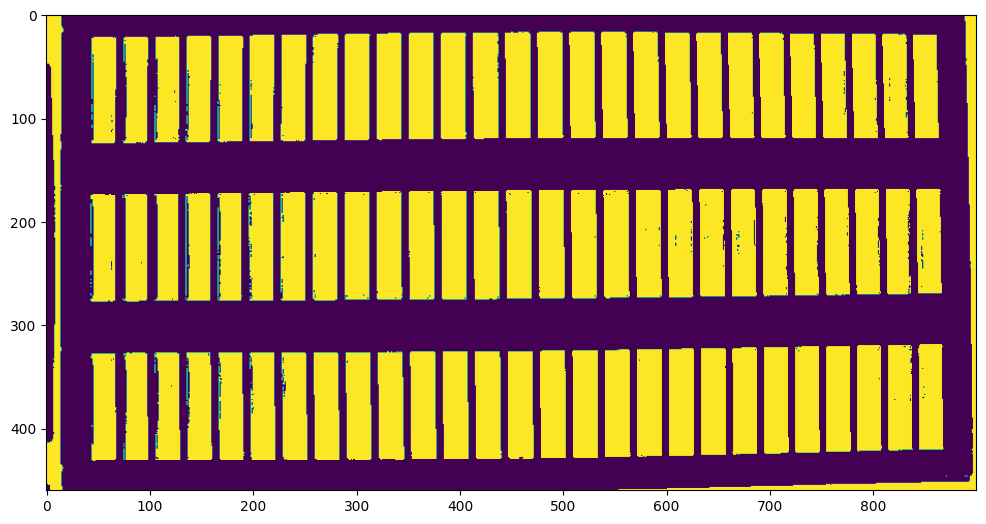

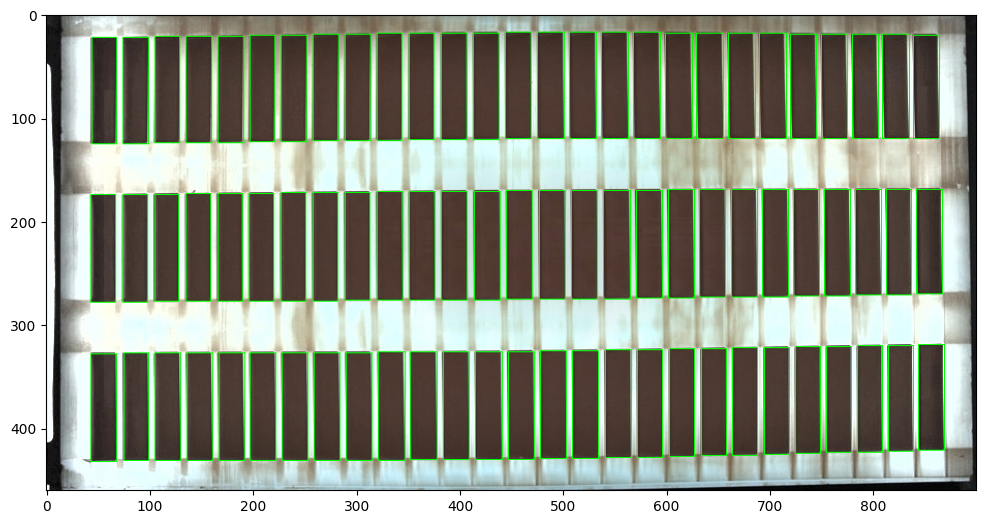

In [10]:
img2 = img0*1

gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)

# Apply thresholding to binarize the image; thresh-value might be critical
_, thresh = cv2.threshold(gray, thresh=70, maxval=255, type=cv2.THRESH_BINARY)


inverted_thresh = 255 - thresh
#plt.imshow(inverted_thresh)

# Find the contours in the image
cnts, _ = cv2.findContours(inverted_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iterate over the contours and draw bounding rectangles around each one


BBOX_EXPECTED_WITH = 26
BBOX_EXPECTED_HEIGHT = 104
BBOX_TOL = 6

bboxes = []


stroke_width = 1

for cnt in cnts:
    x, y, w, h = cv2.boundingRect(cnt)
    if (abs(w - BBOX_EXPECTED_WITH) > BBOX_TOL) or (abs(h - BBOX_EXPECTED_HEIGHT) > BBOX_TOL):
        pass
        continue
    else:
        # print(w, h, "--", abs(w - BBOX_EXPECTED_WITH) > BBOX_TOL, abs(h - BBOX_EXPECTED_HEIGHT) > BBOX_TOL)
        pass
        
    cv2.rectangle(img2,(x,y),(x + w,y + h),(0, 255, 0), stroke_width)
    bboxes.append(np.r_[x, y, w, h])

bboxes = np.array(bboxes)    

plt.imshow(inverted_thresh)
plt.figure()
plt.imshow(rgb(img2))


In [11]:
fpath_res = img_path.replace(".png", f"_grid{stroke_width}px.jpg") ##:
cv2.imwrite(fpath_res, img2, [cv2.IMWRITE_JPEG_QUALITY, 100])

fpath_res := '/media/hdd-a2/space/Nextcloud/tmp2023/2024_11_iee-ge-xaidia/slides/img/preprocessing_3_grid1px.jpg'

---

True

In [17]:
img3 = img2*0+230


idx1, idx2 = 200, 700

img3[:idx1, idx2:, :] = img2[:200, 700:, :]*1

fpath_res = img_path.replace(".png", f"_grid{stroke_width}px_part.jpg") ##:
cv2.imwrite(fpath_res, img3, [cv2.IMWRITE_JPEG_QUALITY, 100])

fpath_res := '/media/hdd-a2/space/Nextcloud/tmp2023/2024_11_iee-ge-xaidia/slides/img/preprocessing_3_grid1px_part.jpg'

---

True

In [18]:
# Ende
1/0

ZeroDivisionError: division by zero

In [4]:
# this was generated from a reference image
if 0:

    xx, yy, ww, hh = bboxes.T
    xx.sort()
    yy.sort()

    dx_mean = np.average(np.diff(xx.reshape(-1, 3), axis=0)) ##:
    dy_mean = np.average(np.diff(yy.reshape(3, -1), axis=0)) ##:
else:
    # average distances between boxes
    dx_mean = 30.73076923076923
    dy_mean = 153.72222222222223

In [136]:
def get_bbbox_list(contour_list):
    res = []
    for cnt in cnts:
        
        x, y, w, h = cv2.boundingRect(cnt)
        if (abs(w - BBOX_EXPECTED_WITH) > BBOX_TOL) or (abs(h - BBOX_EXPECTED_HEIGHT) > BBOX_TOL):
            # in valid bounding box
            continue
        
        
        
        # these values will be assigned later
        row, col = -1, -1
        res.append([x, y, w, h, row, col])
    return res

def assign_row_col(bbox_list):
    """
    problem: The list of bounding boxes is not sorted. it has to be calculated in which row an col every bb is.
    """
    # 3 rows, 27 cols
    
    arr1 = np.array(bbox_list)
    xx, yy, ww, hh, _, _ = arr1.T
    
    xmin = np.min(xx)
    xmax = np.max(xx)
    
    ymin = np.min(yy)
    ymax = np.max(yy)
    
    xx_index_candidates = (xx - xmin)/dx_mean
    yy_index_candidates = (yy - ymin)/dy_mean
    
    xx_idcs = np.int16(xx_index_candidates.round())
    yy_idcs = np.int16(yy_index_candidates.round())
    
    # ensure that it is clear which index each bb refers to
    assert np.max(np.abs(xx_index_candidates - xx_idcs)) < 0.45
    assert np.max(np.abs(yy_index_candidates - yy_idcs)) < 0.45
    
    
    for i, (xx_idx, yy_idx) in enumerate(zip(xx_idcs, yy_idcs)):
        bbox_list[i][4] = yy_idx  # row
        bbox_list[i][5] = xx_idx  # col
        
    
    # sort such that first row comes first
    bbox_list.sort(key=lambda seq: seq[4]*1e4 + seq[5])


def index_combinations():
    return list(it.product(range(3), range(27)))


def find_missing_boxes(bbox_list):
    
    idcs = index_combinations()
    for bbox in bbox_list:
        row_col = tuple(bbox[-2:])
        
        try:
            idcs.remove(row_col)
        except ValueError:
            msg = f"unexpected row_col index pair: {row_col}"
            raise ValueError(msg)
    
    # in the nominal case this list is now empty
    return idcs

def handle_missing_boxes(bbox_list):
    missing_boxes = find_missing_boxes(bbox_list)
    
    if len(missing_boxes) > 0:
        raise NotImplementedError
    
    # TODO: 
    # next steps:
    # - detect missing bboxes
    # - isolate bars
    # - do statistics for each C0-bar (over many sample images)
    # - for every unclassified image: compare each bar to the C0 - statistics
    # -> identify candidates for non-C0 images
    pass

def adapt_rotation_and_margin(bbox, img, forced_angle=None):
    
    x, y, w, h = bbox[:4]
       
    d = 5 # margin added before rotation
    e = d - 1 # margin subtracted after rotation
    part_img = img[y-d:y+h+d, x-d:x + w+d, :]
    
    gray = cv2.cvtColor(part_img, cv2.COLOR_BGR2GRAY)
    
    # generated by perplexity ai

    # Apply Canny edge detection to the grayscale image
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Find contours in the edge image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the rectangle with the largest area
    max_area = 0
    max_rect = None
    for cnt in contours:
        # this determines center, width, height and the angle
        rect = cv2.minAreaRect(cnt)
        area = rect[1][0] * rect[1][1]
        if area > max_area:
            max_area = area
            max_rect = rect

    # Get the rotation angle of the rectangle
    angle = max_rect[2]

    height, width = part_img.shape[:2]

    # adapt the rotation angle
        
    if forced_angle is not None:
        angle = forced_angle
    else:
        if abs(angle) > 45:
            angle = angle - 90
        assert -5 <= angle <= 5

    # Calculate the rotation matrix
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)

    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(part_img, rotation_matrix, (width, height))

    return rotated_image[e:-e, e:-e, :]
    

def convert_to_dict(bbox_list, img):
    
    idcs = index_combinations()
    res = {}
    for idx_pair, bbox in zip(idcs, bbox_list):
        assert list(idx_pair) == bbox[-2:], f"{list(idx_pair)=}  {bbox[-2:]=}"
        
        part_img = adapt_rotation_and_margin(bbox, img, forced_angle=None)
        
        # without rotation:
        if 0: 
            x, y, w, h = bbox[:4]
            part_img = img[y:y+h, x:x + w, :]
        res[idx_pair] = part_img
        
    return res
        
def plot_bbox_hist(contour_list):
    
    bbox_list = get_bbbox_list(contour_list)
    
    fig, aax = plt.subplots(nrows=3, sharex=True, sharey=True,)
    
    
    #for i, (x, y, w, h) in enumerate(bbox_list):
    pass


In [137]:
bbox_list = get_bbbox_list(cnts) ##:i

assign_row_col(bbox_list)
handle_missing_boxes(bbox_list)

row_col_dict = convert_to_dict(bbox_list, img0)

info(bbox_list) := "<class 'list'> with length: 81"

---

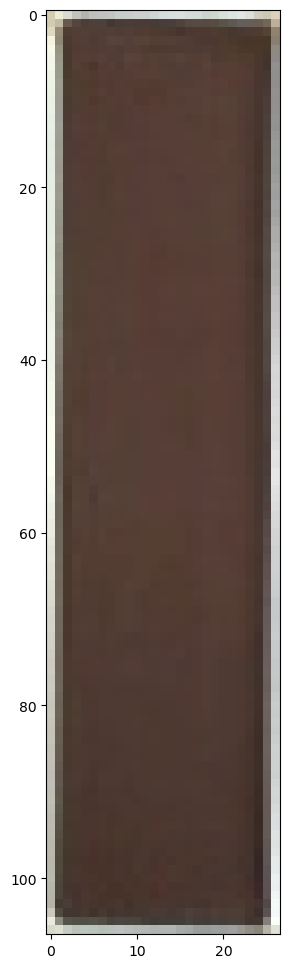

In [138]:
part_img = row_col_dict[(2, 7)]
plt.imshow(rgb(part_img))

angle := 88.8982925415039

---

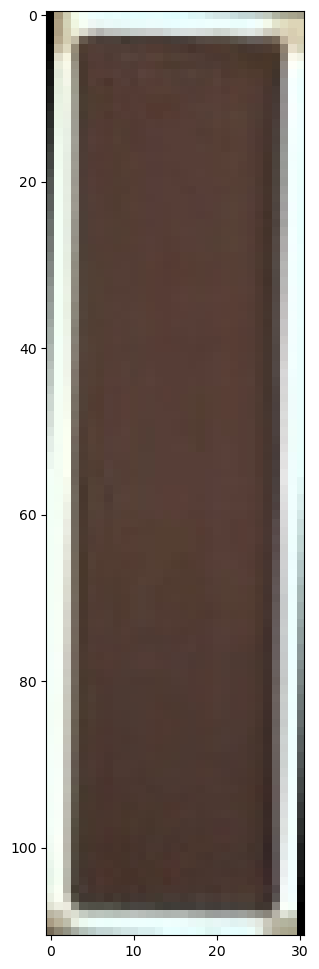

In [85]:
# rotation detection and correction:

gray = cv2.cvtColor(part_img, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection to the grayscale image
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# Find contours in the edge image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the rectangle with the largest area
max_area = 0
max_rect = None
for cnt in contours:
    # this determines center, width, height and the angle
    rect = cv2.minAreaRect(cnt)
    area = rect[1][0] * rect[1][1]
    if area > max_area:
        max_area = area
        max_rect = rect

# Get the rotation angle of the rectangle
angle = max_rect[2] ##:


height, width = part_img.shape[:2]

# Define the rotation angle
angle = angle - 90

# Calculate the rotation matrix
center = (width // 2, height // 2)
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)

# Apply the rotation to the image
rotated_image = cv2.warpAffine(part_img, rotation_matrix, (width, height))

plt.imshow(rgb(rotated_image))



In [82]:
max_rect

((15.480780601501465, 54.000370025634766),
 (108.5376205444336, 26.956554412841797),
 88.8982925415039)

In [80]:
contours

(array([[[ 27, 110]]], dtype=int32),
 array([[[  4, 110]]], dtype=int32),
 array([[[  0, 108]],
 
        [[  1, 108]],
 
        [[  2, 109]],
 
        [[  1, 110]],
 
        [[  2, 109]],
 
        [[  2, 108]]], dtype=int32),
 array([[[29,  4]],
 
        [[30,  4]]], dtype=int32),
 array([[[  1,   0]],
 
        [[  1,   2]],
 
        [[  2,   3]],
 
        [[  2,  39]],
 
        [[  3,  40]],
 
        [[  3, 106]],
 
        [[  5, 108]],
 
        [[ 26, 108]],
 
        [[ 27, 107]],
 
        [[ 28, 107]],
 
        [[ 29, 108]],
 
        [[ 30, 108]],
 
        [[ 29, 108]],
 
        [[ 28, 107]],
 
        [[ 28,  48]],
 
        [[ 27,  47]],
 
        [[ 27,   3]],
 
        [[ 26,   3]],
 
        [[ 25,   2]],
 
        [[  4,   2]],
 
        [[  3,   3]],
 
        [[  2,   3]],
 
        [[  1,   2]]], dtype=int32))

In [45]:
bbox_list[:5]

[[43, 19, 25, 104, 0, 0],
 [74, 19, 25, 104, 0, 1],
 [104, 19, 26, 104, 0, 2],
 [135, 18, 26, 104, 0, 3],
 [165, 18, 26, 104, 0, 4]]

In [46]:
arr = np.array(bbox_list)

In [47]:
xx, yy, ww, hh, xx_idcs, yy_idcs = arr.T

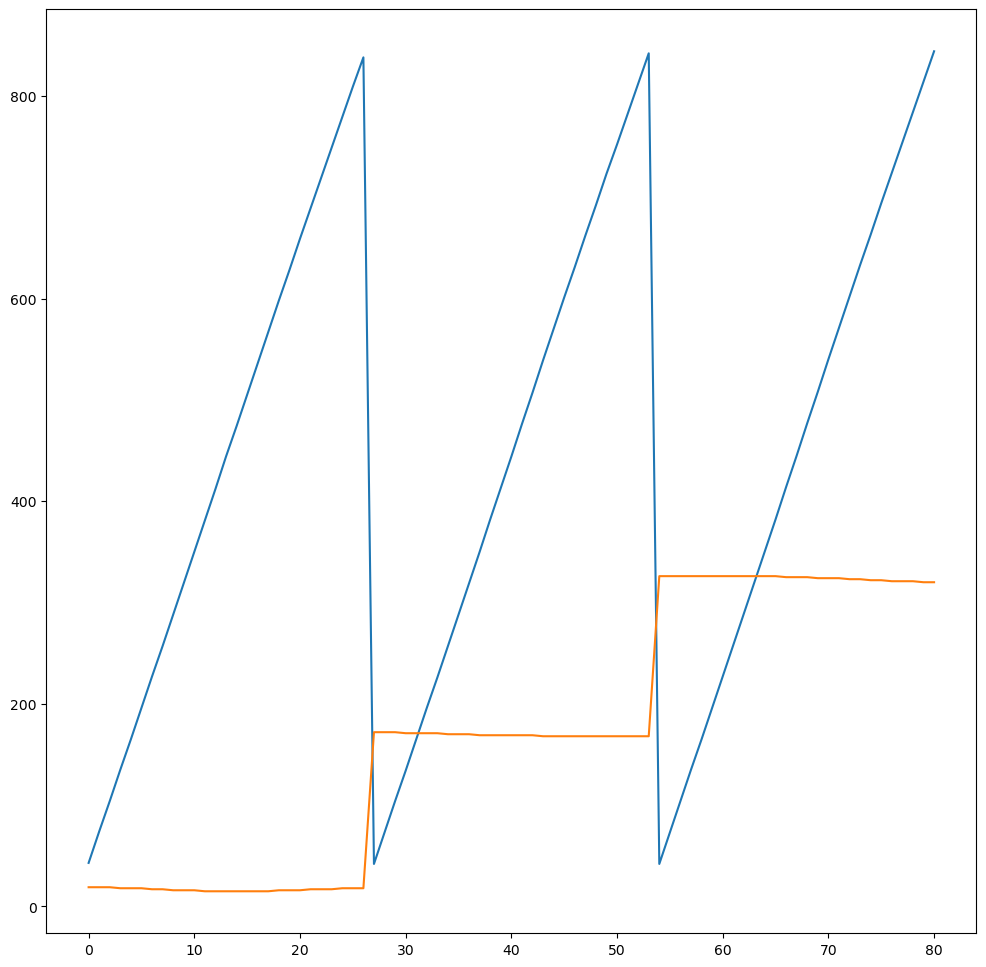

In [48]:
plt.plot(xx)
plt.plot(yy)

In [18]:
for bbox in bbox_list[:5]:
    pass
    # img2[*bbox]
    

In [71]:
print(f"{3:02d}")

03


In [19]:
bbox

[165, 18, 26, 104, 4, 0]

In [59]:
a- np.round(a)

TypeError: loop of ufunc does not support argument 0 of type float which has no callable rint method

In [13]:
qq = get_bbbox_arr(cnts)

In [14]:
qq.shape

(105, 4)

In [25]:
bboxes.shape

(81, 4)

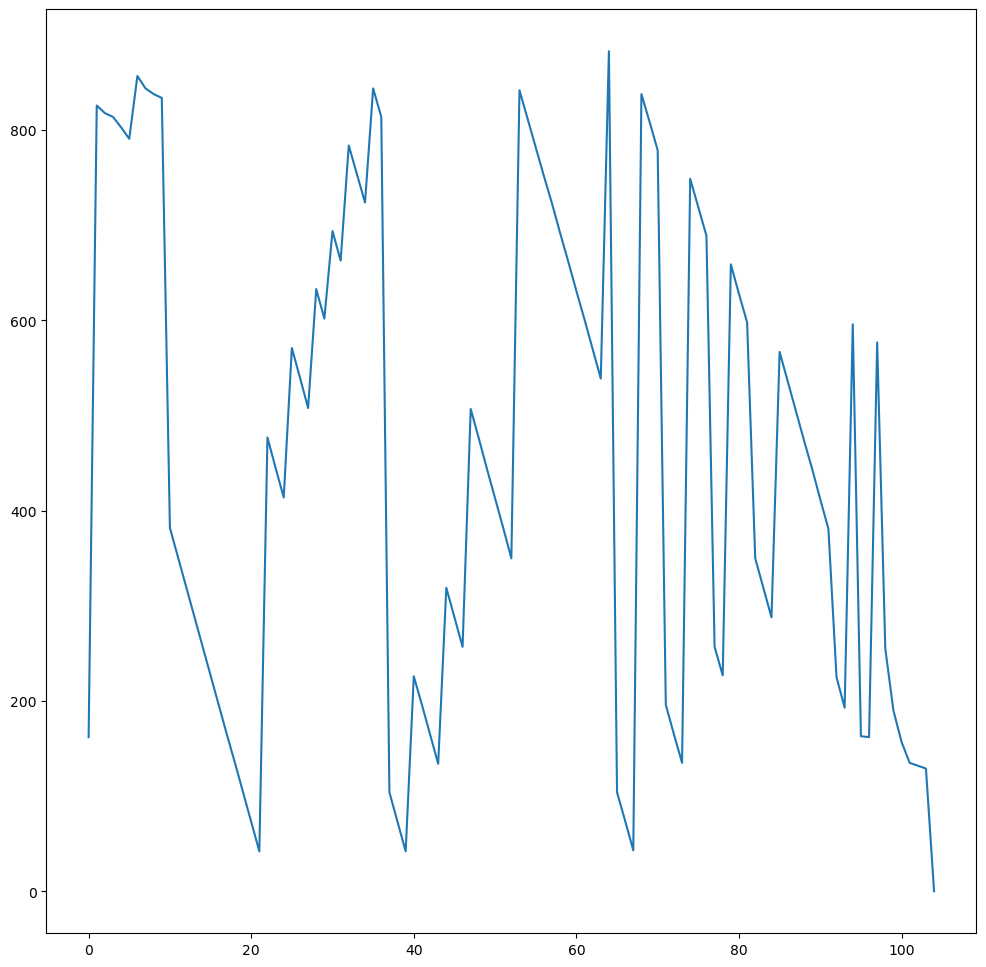

In [27]:
plt.plot(qq[:, 0])

(81,)

In [22]:
len(ww)

105

In [23]:
hh

array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1, 105, 105, 105,
       105, 105, 105, 105, 105, 105, 105, 105, 106, 105, 106, 106, 105,
       105, 106, 105, 105, 104, 105, 103, 104, 104, 103, 103, 105, 105,
       105, 105, 106, 106, 106, 106, 106, 106, 106, 106, 106, 107, 107,
       107, 103, 104, 104, 104, 105, 105, 105, 106, 106, 106, 107,   1,
       104, 104, 104, 102, 102, 102, 104, 104, 104, 103, 103, 103, 104,
       104, 104, 104, 103, 104, 104, 105, 104, 104, 104, 104, 104, 105,
       105,   1,   1,   1,   9,   7, 460,   2,  12,   9,   2,   4,   1,
       460])